Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

## Background
ADME@NCATS is a resource developed by NCATS to host in silico prediction models for various ADME (Absorption, Distribution, Metabolism and Excretion) properties. The resource serves as an important tool for the drug discovery community with potential uses in compound optimization and prioritization. The models were retrospectively validated on a subset of marketed drugs which resulted in very good accuracies.

Data that were used for developing the models are made publicly accessible by depositing them into PubChem database. In some instances, when complete data cannot be made public, a subset of the data are deposited into PubChem. Links to the PubChem assays can be found in the individual model pages. The users are highly encouraged to use these data for development and validation of QSAR models.

## Assay Information
Cytochrome P450 (CYP) enzymes are membrane-bound hemeproteins that play a key role in metabolism of drugs and xenobiotics. Assaying the effect of chemicals on CYP isozymes is useful to minimize the adverse drug reactions and toxicities in drug development process. Chemical compounds were tested for their effect on CYP enzyme activities by using P450-Glo (TM) screening systems (Promega Corporation, Madison, WI). These systems provide a luminescent method containing proluciferin substrates and are converted to luciferin products by CYP isozymes. The luciferin products formed are detected with a luciferin detection reagent, and the amount of light produced is proportional to CYP activity. P450-Glo (TM) CYP2D6 screening system (Catalog. No. V9890) was used to detect the compounds that interfere in CYP2D6 activity. The positive control compound used for CYP2D6 assay is quinidine (Sigma-Aldrich, St. Louis, MO).

## Description of readout:
- **PUBCHEM_ACTIVITY_OUTCOME**: Corresponds to PUBCHEM_ACTIVITY_SCORE. For all inactive compounds, PUBCHEM_ACTIVITY_SCORE is 0. For all active compounds, a score range was given for each curve class type given above. Active antagonist compounds have PUBCHEM_ACTIVITY_SCORE between 40 and 100. Inconclusive compounds had PUBCHEM_ACTIVITY_SCORE between 1 and 39, and were removed in processing. 
- **PUBCHEM_ACTIVITY_SCORE**: Average of 5 experimental replicates. Fit_LogAC50 was used for determining relative score and was scaled to each curve class' score range.

## Data resource

**Raw data**: 
- CYP2D6: https://pubchem.ncbi.nlm.nih.gov/bioassay/1645840
- CYP3A4: https://pubchem.ncbi.nlm.nih.gov/bioassay/1645841
- CYP2C9: https://pubchem.ncbi.nlm.nih.gov/bioassay/1645842

In [1]:
%load_ext autoreload
%autoreload 2
    
import datamol as dm

from polaris import (
    curation,
    load_dataset,
)
from polaris.curation.viz_utils import (
    visualize_distribution,
    verify_stereoisomers,
    check_undefined_stereocenters,
)
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.utils.types import HubOwner, License
from polaris.hub.client import PolarisHubClient

import tempfile

import pandas as pd
import numpy as np
import utils
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

All datasets were downloaded directly from Pubchem on 2024-03-21 by following the PubChem Bioassay links on https://opendata.ncats.nih.gov/adme/data. \
The same set of molecules were testes for CYPs assays, therefore we merge those three datasets into one. 

In [3]:
aids = ['AID_1645840', 'AID_1645841', 'AID_1645842']
names = ['CYP2D6', 'CYP3A4', 'CYP2C9']
sources = ['https://pubchem.ncbi.nlm.nih.gov/bioassay/1645840', 'https://pubchem.ncbi.nlm.nih.gov/bioassay/1645841', 'https://pubchem.ncbi.nlm.nih.gov/bioassay/1645842']
mol_col = 'SMILES'
datasets = []
mol_id_cols = ['PUBCHEM_SID','PUBCHEM_CID',  mol_col ]
data_cols = []
# Looking at the files previously (not shown) indicates metadata rows are 0-4
meta_start = 0 # Start row index
meta_end = 5 # End row index + 1
merged_data = pd.DataFrame(columns=mol_id_cols)
for name, aid in zip(names, aids):
    # Load the dataset
    data = pd.read_parquet(f'gs://polaris-public/data/raw/ADME_NCATS/{aid}_raw.parquet')
    # Remove the metadata rows
    data = data.drop(labels=list(range(meta_start, meta_end)), axis=0).reset_index(drop=True)
    print(f'{name} initial dataset size: {len(data)}')
    # Remap the outcome to binary
    data['PUBCHEM_ACTIVITY_OUTCOME'] = data['PUBCHEM_ACTIVITY_OUTCOME'].map({'Active':1.0, 'Inactive':0.0}) # Inconclusive compounds will be converted to nan and removed
    # Rename the smiles column
    data.rename(columns = {'PUBCHEM_EXT_DATASOURCE_SMILES' : 'SMILES', 'PUBCHEM_ACTIVITY_OUTCOME': f'{name}_OUTCOME', 'PUBCHEM_ACTIVITY_SCORE': f'{name}_SCORE'}, inplace = True)
    
    # Define data column names
    endpoints = [
        f'{name}_OUTCOME',
        f'{name}_SCORE',
    ]
    data_cols.extend(endpoints)
    
    # Narrow the dataframe to just the data_cols and mol_col
    data=data[mol_id_cols + endpoints]
    # Drop any nans
    data.dropna(axis=0, ignore_index=True, inplace = True)
    data[['PUBCHEM_SID','PUBCHEM_CID']] = data[['PUBCHEM_SID','PUBCHEM_CID']].astype(int)
    merged_data = pd.concat([merged_data, data[mol_id_cols]])
    print(f'{name} data before curation, after dropping nans: {len(data)}')
    
    # Store the curated dataset in the list
    datasets.append(data)

CYP2D6 initial dataset size: 5242
CYP2D6 data before curation, after dropping nans: 4276
CYP3A4 initial dataset size: 5242
CYP3A4 data before curation, after dropping nans: 4346
CYP2C9 initial dataset size: 5242
CYP2C9 data before curation, after dropping nans: 4461


Because these data are similar/linked and there is overlap between the molecules from the different datasets, we could also combine the data and upload one dataframe.

In [4]:
merged_data = merged_data.drop_duplicates(subset=mol_id_cols, ignore_index=True)
merged_data.shape

(5199, 3)

Fill up the matrix with `CYP2D6`, `CYP3A4`, `CYP2C9` values.

In [5]:
for data in datasets:
    merged_data = merged_data.merge(right=data, on=mol_id_cols, how="outer")
    print(merged_data.shape)

(5199, 5)
(5199, 7)
(5199, 9)


In [6]:
data = merged_data.copy()

In [7]:
data_cols

['CYP2D6_OUTCOME',
 'CYP2D6_SCORE',
 'CYP3A4_OUTCOME',
 'CYP3A4_SCORE',
 'CYP2C9_OUTCOME',
 'CYP2C9_SCORE']

In [8]:
# Curate, dropping duplicates if they exist
curator = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    data_types = ["binary", "continuous"] *3,
    mol_col=mol_col,
    mask_stereo_undefined_mols=False,
    keep_all_rows = True
)
data_look = curator()

2024-04-09 10:53:26.730 | INFO     | polaris.curation._data_curator:check_outliers:176 - Outlier detection is omit for categorical data CYP2D6_OUTCOME.
2024-04-09 10:53:26.733 | INFO     | polaris.curation._data_curator:check_outliers:176 - Outlier detection is omit for categorical data CYP3A4_OUTCOME.
2024-04-09 10:53:26.734 | INFO     | polaris.curation._data_curator:check_outliers:176 - Outlier detection is omit for categorical data CYP2C9_OUTCOME.


2024-04-09 10:53:28.107 | WARNING  | polaris.curation.readouts:detailed_distributions_plots:451 - Threshold not available for readout 'CYP2D6_SCORE'
2024-04-09 10:53:28.167 | WARNING  | polaris.curation.readouts:detailed_distributions_plots:451 - Threshold not available for readout 'CYP3A4_SCORE'
2024-04-09 10:53:28.230 | WARNING  | polaris.curation.readouts:detailed_distributions_plots:451 - Threshold not available for readout 'CYP2C9_SCORE'


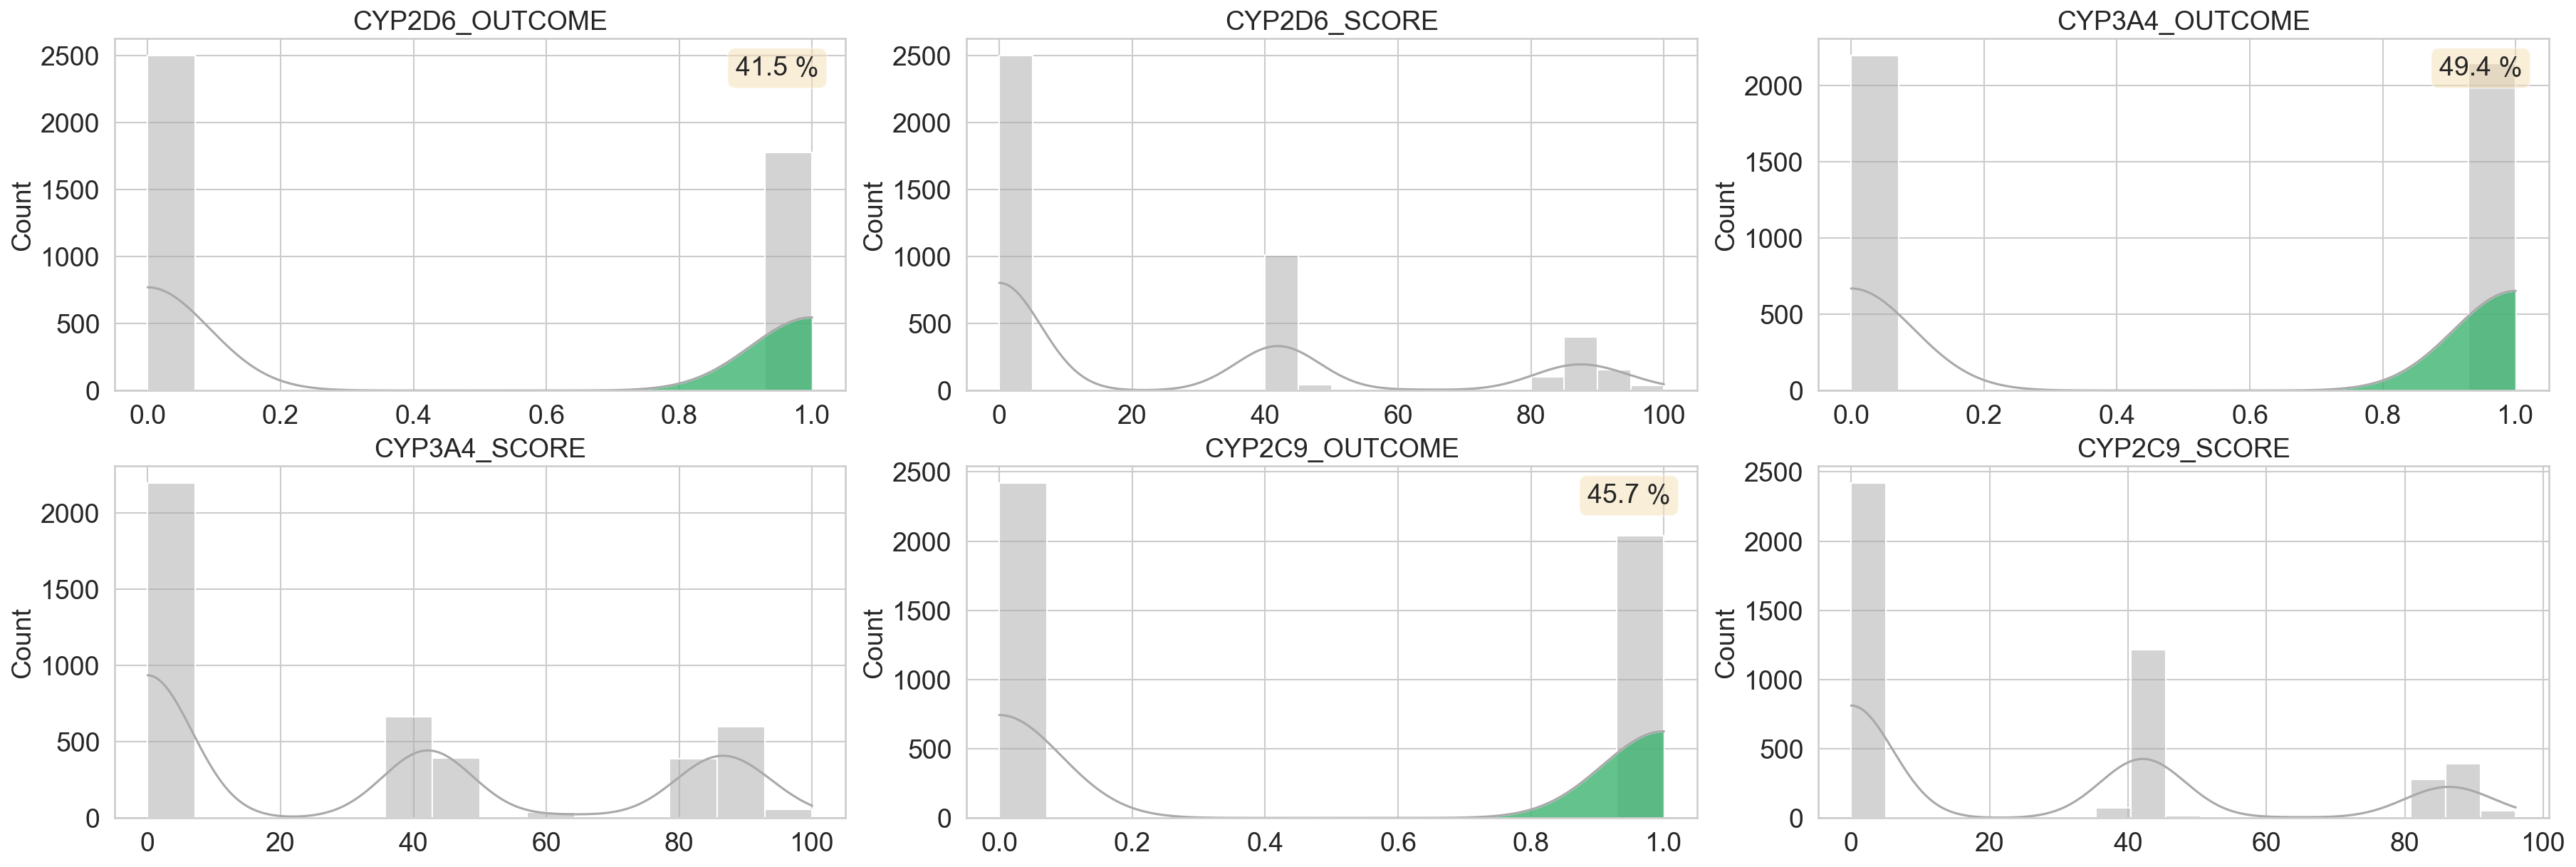

In [9]:
# Distribution plot of all related readouts
from polaris.curation.readouts import detailed_distributions_plots

fig = detailed_distributions_plots(df=data_look[data_cols], 
                                   thresholds={col: (0.5, np.greater) for col in data_cols if "OUTCOME" in col})

For each dataset, there is an approximately 50-50 split between active and inactive samples. This is not realistic in a drug discovery program but may still be useful in training models.

The data columns based on `PUBCHEM_ACTIVITY_SCORE` are a mixture of score range and zeros for inactives computed based on the titiration curves. Therefore, 
the normal distribution plot won't be helpful here. 

### Check activity shift between stereoisomers

In [10]:
data_look[[col for col in data_look.columns if "stereo_cliff" in col]].sum()

CYP2D6_OUTCOME_stereo_cliff    10
CYP2D6_SCORE_stereo_cliff       0
CYP3A4_OUTCOME_stereo_cliff    10
CYP3A4_SCORE_stereo_cliff       0
CYP2C9_OUTCOME_stereo_cliff    24
CYP2C9_SCORE_stereo_cliff       0
dtype: object

Few activity shifts were detected in the dataset.
Let's check those isomers. 

In [13]:
# CYP2D6
data_look.query("CYP2D6_OUTCOME_stereo_cliff == True").sort_values("molhash_id_no_stereo")

,PUBCHEM_SID,PUBCHEM_CID,SMILES,CYP2D6_OUTCOME,CYP2D6_SCORE,CYP3A4_OUTCOME,CYP3A4_SCORE,CYP2C9_OUTCOME,CYP2C9_SCORE,ORIGINAL_CYP2D6_OUTCOME,...,OUTLIER_CYP2C9_SCORE,CYP2D6_OUTCOME_stereo_cliff,CYP2D6_SCORE_zscore,CYP2D6_SCORE_stereo_cliff,CYP3A4_OUTCOME_stereo_cliff,CYP3A4_SCORE_zscore,CYP3A4_SCORE_stereo_cliff,CYP2C9_OUTCOME_stereo_cliff,CYP2C9_SCORE_zscore,CYP2C9_SCORE_stereo_cliff
11,124890308,25762893,C[C@]12CCC(=O)C=C1CC[C@H]3[C@@H]2CC[C@]4([C@@H...,1.0,40.0,0.0,0.0,1.0,40.0,1.0,...,False,True,inf,NaN,NaN,NaN,NaN,True,inf,NaN
317,170464631,6010,C[C@]12CCC(=O)C=C1CC[C@@H]3[C@@H]2CC[C@]4([C@H...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,True,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
2773,363677525,25262792,C[C@H]1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=CC=C...,0.0,0.0,NaN,NaN,1.0,42.0,0.0,...,False,True,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN
4114,440681558,25262792,C[C@H]1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=CC=C...,1.0,41.0,NaN,NaN,1.0,42.0,1.0,...,False,True,inf,NaN,NaN,NaN,NaN,NaN,inf,NaN
2666,363677195,57519550,CC1C(=N)N(C2=CN=C(N=C2N1CCC(C)C)NC3=CC(=C(C(=C...,0.0,0.0,1.0,43.0,1.0,43.0,0.0,...,False,True,NaN,NaN,NaN,inf,NaN,NaN,inf,NaN
3933,440681328,57519550,CC1C(=N)N(C2=CN=C(N=C2N1CCC(C)C)NC3=CC(=C(C(=C...,1.0,41.0,1.0,44.0,1.0,86.0,1.0,...,False,True,inf,NaN,NaN,inf,NaN,NaN,inf,NaN
3816,404904707,16720766,C1CC2=CC=CC=C2[C@H]1NC3=C4C=CN(C4=NC=N3)[C@@H]...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,None,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4199,440681667,16720766,C1CC2=CC=CC=C2[C@H]1NC3=C4C=CN(C4=NC=N3)[C@@H]...,1.0,43.0,0.0,0.0,1.0,41.0,1.0,...,False,True,inf,NaN,NaN,NaN,NaN,NaN,inf,NaN
276,144214009,4004,CCOC(=O)CC(C(=O)OCC)SP(=S)(OC)OC,1.0,40.0,1.0,84.0,1.0,88.0,1.0,...,False,True,inf,NaN,NaN,inf,NaN,NaN,inf,NaN
882,170465311,4004,CCOC(=O)CC(C(=O)OCC)SP(=S)(OC)OC,0.0,0.0,1.0,42.0,1.0,85.0,0.0,...,False,True,NaN,NaN,NaN,inf,NaN,NaN,inf,NaN


2024-04-09 10:59:17.650 | INFO     | polaris.curation.viz_utils:verify_stereoisomers:60 - Verify the stereo ismomers for readout `CYP2D6_OUTCOME`


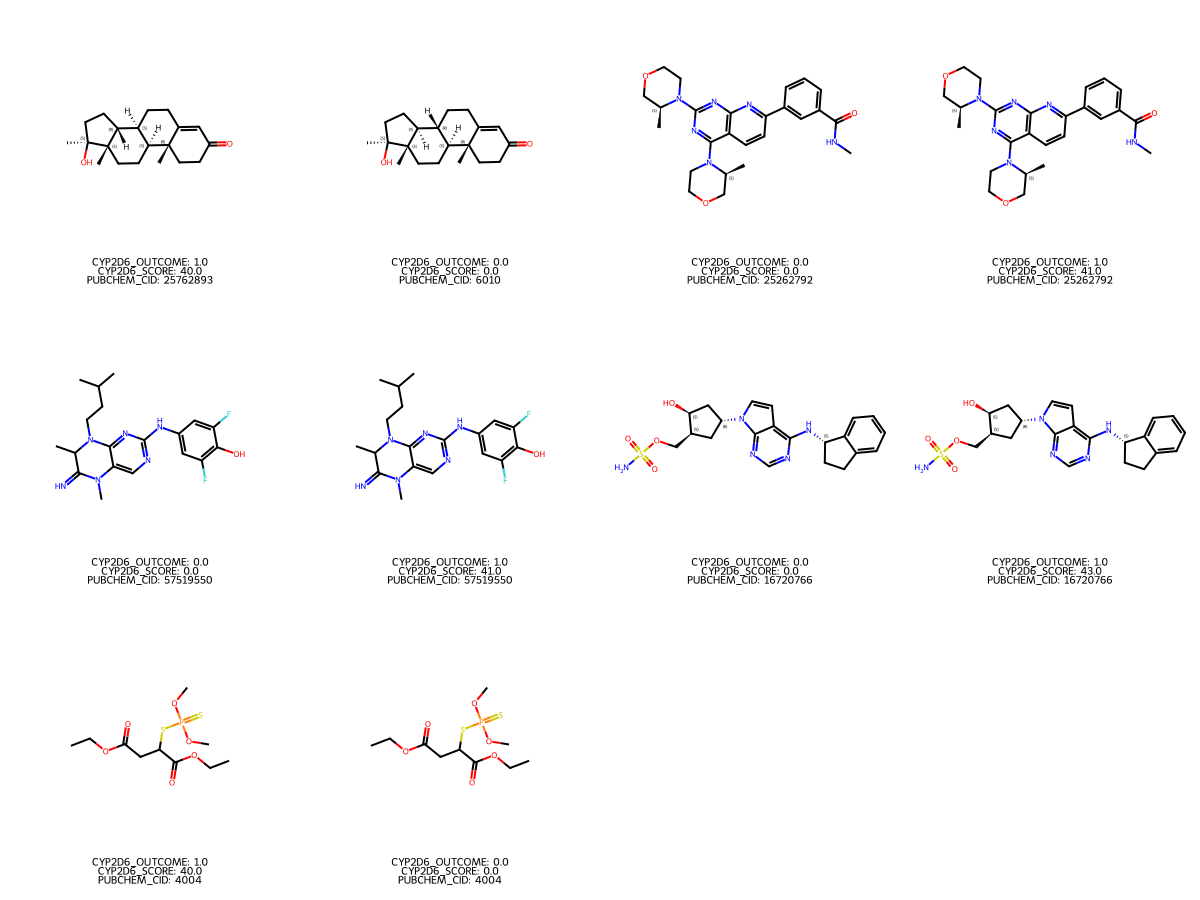

In [15]:
from polaris.curation.viz_utils import verify_stereoisomers
figs = verify_stereoisomers(data_cols=["CYP2D6_OUTCOME"], dataset=data_look, legend_cols=["CYP2D6_SCORE",'PUBCHEM_CID'], mol_col=mol_col)
figs[0]

The stereoisomers `CID:25762893` and `CID:6010` are active and inactive in CYP2D6 bioassay. The stereochemical differences are the hydrgens highligted in smiles k'C[C@]12CCC(=O)C=C1CC **[C@H]3** [C@@H]2CC[C@]4( **[C@@H]3** CC[C@]4(C)O)C', 'C[C@]12CCC(=O)C=C1CC **[C@@H]3** [C@@H]2CC[C@]4( **[C@H]3** CC[C@]4(C)O)C'.  \
This indicate the  CYP2D6 activity is sensitive to stereo chemistry information of molecules. It requires the molecular representations which are capable of capture such information for downstream machine learning modeling.

The rest of molecules of the table, `CID:25262792`, `CID:16720766`, `CID:57519550` and `CID:4004` are the same molecules which might be from different providers. Or such activity difference can be the results from experimental noise.  

The `CYP2D6_OUTCOME` is based on a hard thresholding at 40 on `CYP2D6_SCORE` value. The `CYP2D6_SCORE` of the above active molecules are on the borderline. Without any further of detail of this experiment, we recommand to remove them

In [20]:
mols_to_mask = [25262792, 57519550, 16720766, 4004]
data.loc[data.PUBCHEM_CID.isin(mols_to_mask), "CYP2D6_OUTCOME"] = None

In [21]:
# CYP2D6
data_look.query("CYP3A4_OUTCOME_stereo_cliff== True").sort_values("molhash_id_no_stereo")

,PUBCHEM_SID,PUBCHEM_CID,SMILES,CYP2D6_OUTCOME,CYP2D6_SCORE,CYP3A4_OUTCOME,CYP3A4_SCORE,CYP2C9_OUTCOME,CYP2C9_SCORE,ORIGINAL_CYP2D6_OUTCOME,...,OUTLIER_CYP2C9_SCORE,CYP2D6_OUTCOME_stereo_cliff,CYP2D6_SCORE_zscore,CYP2D6_SCORE_stereo_cliff,CYP3A4_OUTCOME_stereo_cliff,CYP3A4_SCORE_zscore,CYP3A4_SCORE_stereo_cliff,CYP2C9_OUTCOME_stereo_cliff,CYP2C9_SCORE_zscore,CYP2C9_SCORE_stereo_cliff
2661,363677084,62891,C1C[C@H](C(NC1)CC(=O)CN2C=NC3=CC(=C(C=C3C2=O)C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
4293,144206292,60196305,C1C[C@H]([C@@H](NC1)CC(=O)CN2C=NC3=CC(=C(C=C3C...,NaN,NaN,1.0,43.0,NaN,NaN,NaN,...,None,NaN,NaN,NaN,True,inf,NaN,NaN,NaN,NaN
1093,170465568,7619,C1COCCN1SC2=NC3=CC=CC=C3S2,0.0,0.0,0.0,0.0,1.0,41.0,0.0,...,False,NaN,NaN,NaN,True,NaN,NaN,NaN,inf,NaN
4290,144204527,7619,C1COCCN1SC2=NC3=CC=CC=C3S2,NaN,NaN,1.0,40.0,1.0,42.0,NaN,...,False,NaN,NaN,NaN,True,inf,NaN,NaN,inf,NaN
811,170465221,4197,CC1=C(C=C(C(=O)N1)C#N)C2=CC=NC=C2,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,None,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
4323,144214030,4197,CC1=C(C=C(C(=O)N1)C#N)C2=CC=NC=C2,NaN,NaN,1.0,40.0,1.0,40.0,NaN,...,False,NaN,NaN,NaN,True,inf,NaN,NaN,inf,NaN
1110,170465591,135409535,CC1=C(C2=C(C=C1)N=C(NC2=O)N)SC3=CC=NC=C3.Cl.Cl,1.0,82.0,0.0,0.0,NaN,NaN,1.0,...,None,NaN,inf,NaN,True,NaN,NaN,NaN,NaN,NaN
3980,440681390,135400184,CC1=C(C2=C(C=C1)N=C(NC2=O)N)SC3=CC=NC=C3,1.0,42.0,1.0,87.0,NaN,NaN,1.0,...,None,NaN,inf,NaN,True,inf,NaN,NaN,NaN,NaN
84,144206364,6540478,CC[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)OC(=O...,1.0,84.0,1.0,87.0,1.0,88.0,1.0,...,False,NaN,inf,NaN,True,inf,NaN,NaN,inf,NaN
4344,170464733,6540478,CC[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)OC(=O...,NaN,NaN,0.0,0.0,1.0,43.0,NaN,...,False,NaN,NaN,NaN,True,NaN,NaN,NaN,inf,NaN


2024-04-09 11:26:52.278 | INFO     | polaris.curation.viz_utils:verify_stereoisomers:60 - Verify the stereo ismomers for readout `CYP3A4_OUTCOME`


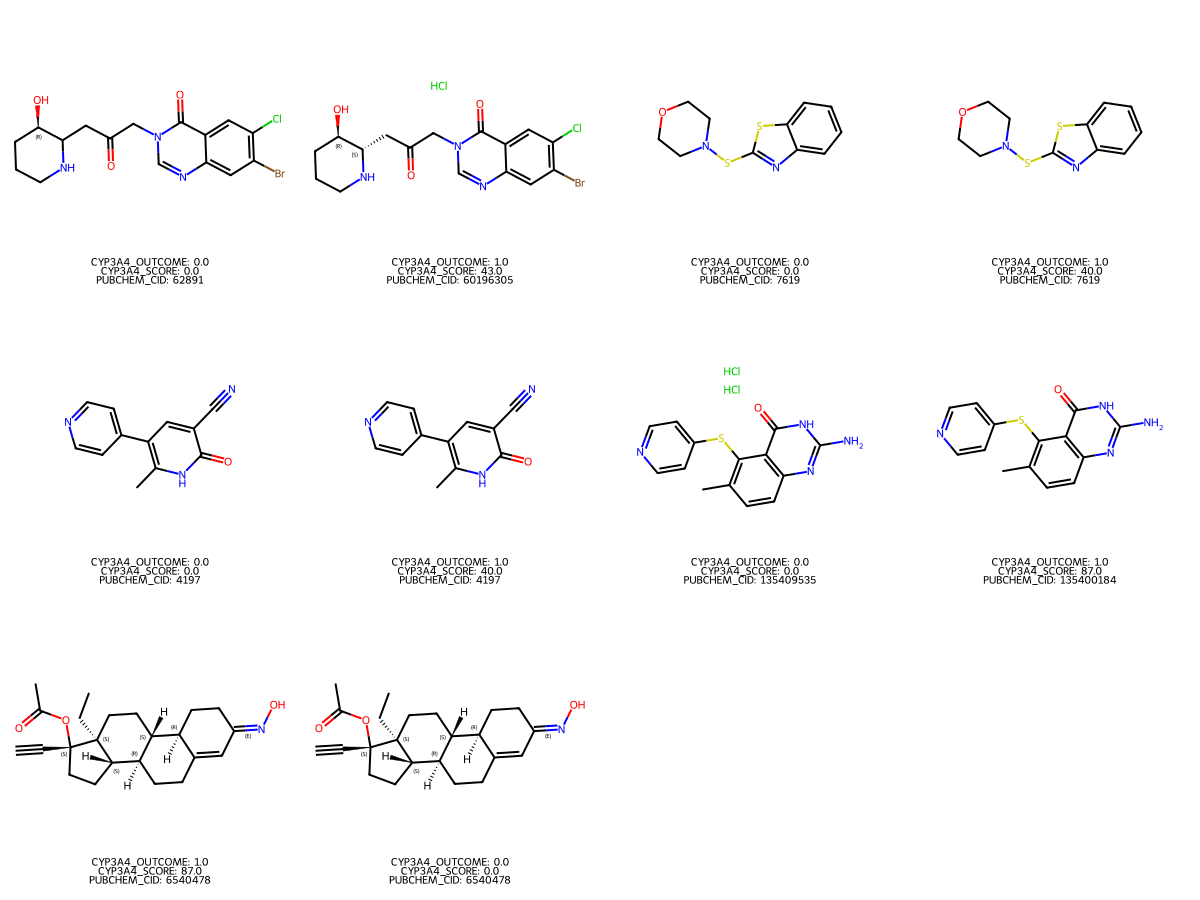

In [24]:
from polaris.curation.viz_utils import verify_stereoisomers
figs = verify_stereoisomers(data_cols=["CYP3A4_OUTCOME"], dataset=data_look, legend_cols=['CYP3A4_SCORE', 'PUBCHEM_CID' ], mol_col="SMILES")
figs[0]

In the case of `CYP3A4`, compound `CID:62891` is not fully annotated with stereochemistry information at the position "O=C(C**C**1NCCC[C@H]1O)Cn1cnc2cc(Br)c(Cl)cc2c1=O".  \
It's likely the unspecified molecule is the mixture of both isomers 'O=C(C **[C@@H]** 1NCCC[C@H]1O)Cn1cnc2cc(Br)c(Cl)cc2c1=O' and 'O=C(C **[C@H]** 1NCCC[C@H]1O)Cn1cnc2cc(Br)c(Cl)cc2c1=O' in the bioassay. However, this cannot be confirmed based on the information available in PubChem bioassay. Therefore, we recommend removing this molecule from the dataset to ensure that downstream modeling is not affected by conflicting values.

For the molecule pair `CID:135409535` and `CID:135400184`. It's hard to judge whether the activity shift is due to the salt (hydrochloric acid), the quality of tested compounds or the experimental error. We would recommand to remove these two molecules from dataset. 

Similarly, the duplicated molecules with conflicting bioactivities should also be removed. 


In [26]:
mols_to_mask =  [62891, 7619,  4197, 135409535, 135400184, 6540478]

data.loc[data.PUBCHEM_CID.isin(mols_to_mask), "CYP3A4_OUTCOME"] = None

In [27]:
# CYP2C9
data_look.query("CYP2C9_OUTCOME_stereo_cliff== True").sort_values("molhash_id_no_stereo")

,PUBCHEM_SID,PUBCHEM_CID,SMILES,CYP2D6_OUTCOME,CYP2D6_SCORE,CYP3A4_OUTCOME,CYP3A4_SCORE,CYP2C9_OUTCOME,CYP2C9_SCORE,ORIGINAL_CYP2D6_OUTCOME,...,OUTLIER_CYP2C9_SCORE,CYP2D6_OUTCOME_stereo_cliff,CYP2D6_SCORE_zscore,CYP2D6_SCORE_stereo_cliff,CYP3A4_OUTCOME_stereo_cliff,CYP3A4_SCORE_zscore,CYP3A4_SCORE_stereo_cliff,CYP2C9_OUTCOME_stereo_cliff,CYP2C9_SCORE_zscore,CYP2C9_SCORE_stereo_cliff
883,170465312,54891,CCOC(=O)[C@H](CCC1=CC=CC=C1)N[C@@H](C)C(=O)N2C...,0.0,0.0,1.0,83.0,1.0,42.0,0.0,...,False,NaN,NaN,NaN,NaN,inf,NaN,True,inf,NaN
4058,440681485,54892,CCOC(=O)[C@H](CCC1=CC=CC=C1)N[C@@H](C)C(=O)N2C...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
3252,363680184,135564570,C1COCCN1CC2=CN=C(C=C2)C3=C(NC4=C3C=C(C=C4)C#N)O,1.0,42.0,1.0,42.0,0.0,0.0,1.0,...,False,NaN,inf,NaN,NaN,inf,NaN,True,NaN,NaN
3606,363680752,135564570,C1COCCN1CC2=CN=C(C=C2)C3=C(NC4=C3C=C(C=C4)C#N)O,1.0,44.0,1.0,84.0,1.0,41.0,1.0,...,False,NaN,inf,NaN,NaN,inf,NaN,True,inf,NaN
954,170465393,123596,CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
4111,440681554,5291,CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...,0.0,0.0,1.0,42.0,1.0,40.0,0.0,...,False,NaN,NaN,NaN,NaN,inf,NaN,True,inf,NaN
11,124890308,25762893,C[C@]12CCC(=O)C=C1CC[C@H]3[C@@H]2CC[C@]4([C@@H...,1.0,40.0,0.0,0.0,1.0,40.0,1.0,...,False,True,inf,NaN,NaN,NaN,NaN,True,inf,NaN
317,170464631,6010,C[C@]12CCC(=O)C=C1CC[C@@H]3[C@@H]2CC[C@]4([C@H...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,True,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
690,170465079,444030,C1CN(C[C@@H]1C(C2=CC=CC=C2)(C3=CC=CC=C3)C(=O)N...,1.0,89.0,0.0,0.0,0.0,0.0,1.0,...,False,NaN,inf,NaN,NaN,NaN,NaN,True,NaN,NaN
4202,440681670,22842821,C1CN(C[C@H]1C(C2=CC=CC=C2)(C3=CC=CC=C3)C(=O)N)...,1.0,96.0,NaN,NaN,1.0,41.0,1.0,...,False,NaN,inf,NaN,NaN,NaN,NaN,True,inf,NaN


2024-04-09 11:28:51.139 | INFO     | polaris.curation.viz_utils:verify_stereoisomers:60 - Verify the stereo ismomers for readout `CYP2C9_OUTCOME`


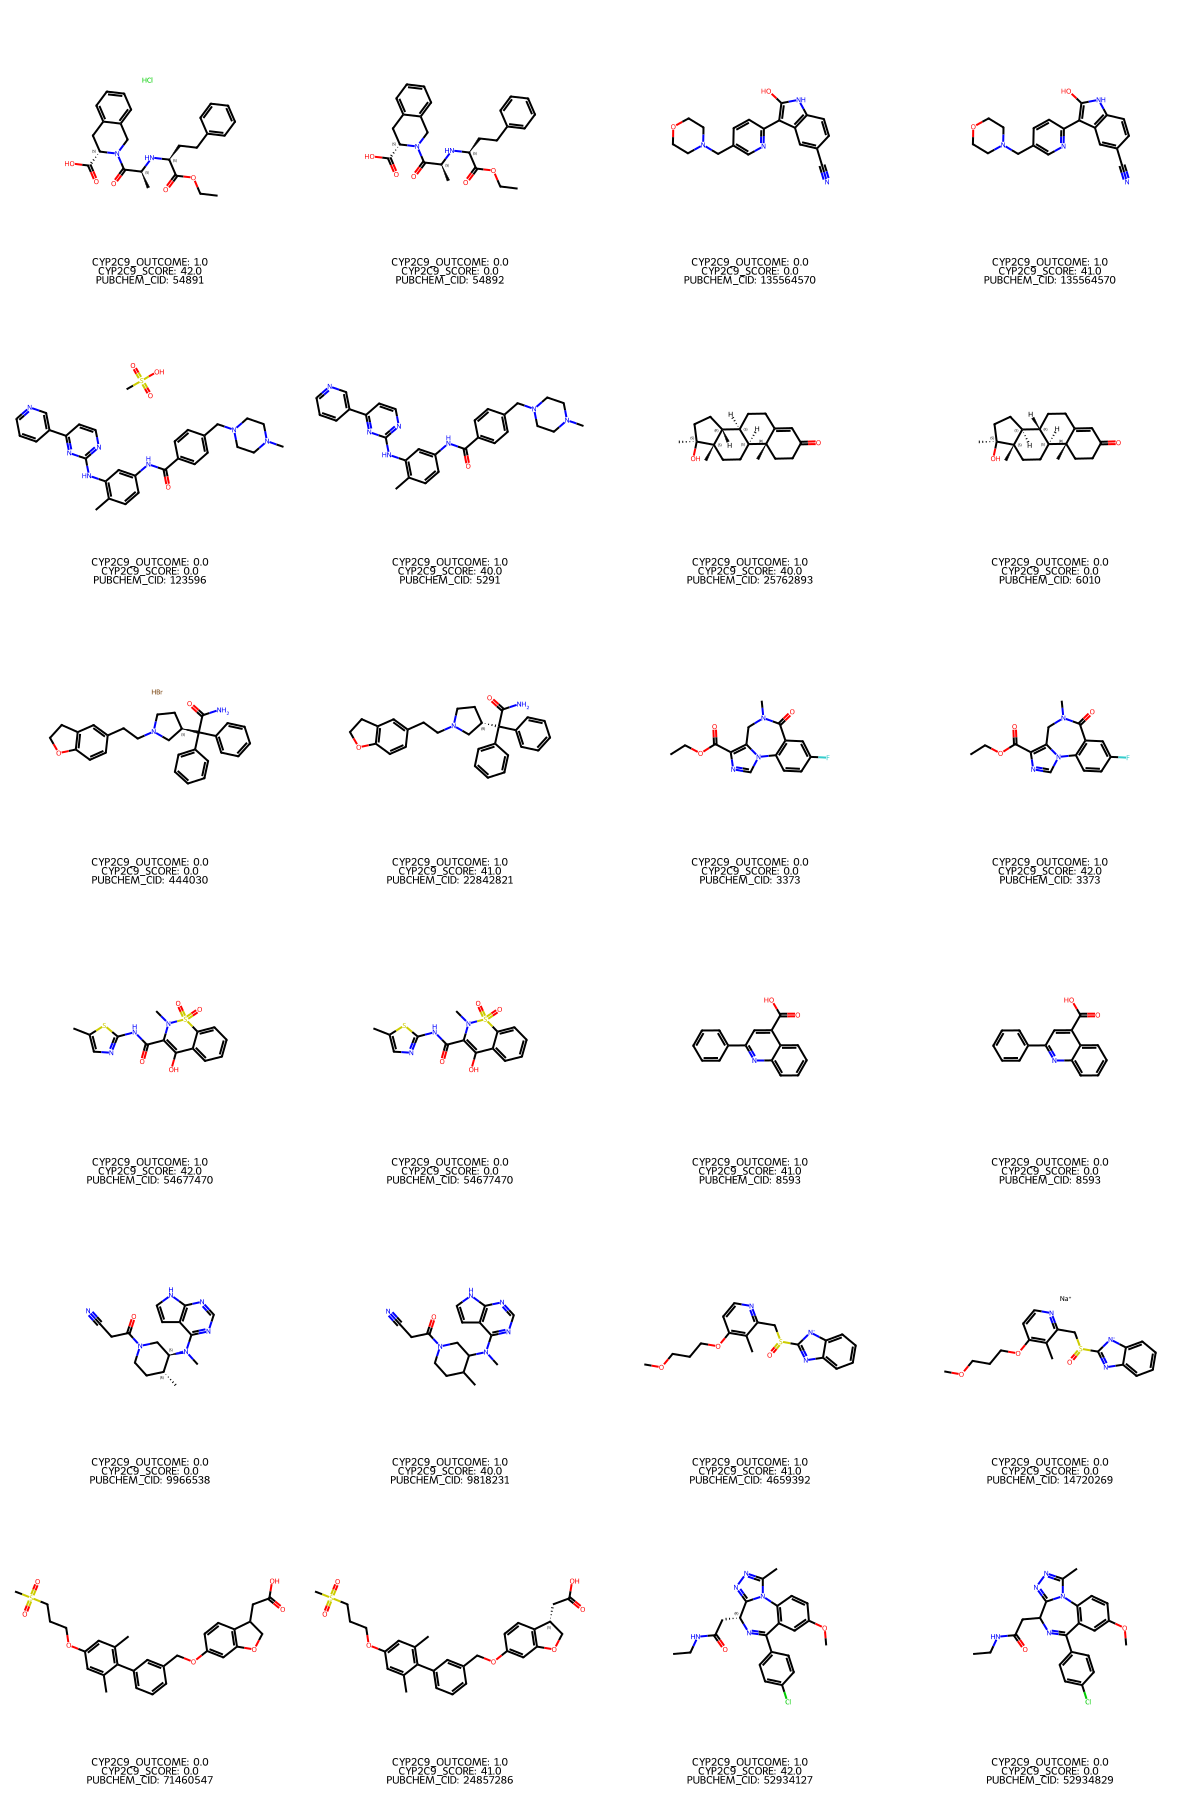

In [28]:
from polaris.curation.viz_utils import verify_stereoisomers
figs = verify_stereoisomers(data_cols=["CYP2C9_OUTCOME"], dataset=data_look, legend_cols=['CYP2C9_SCORE', 'PUBCHEM_CID'], mol_col=mol_col)
figs[0]

The isomers with opposite activity class `CID:25762893/CID:6010`, `CIDL22842821/CID444030` indicate that `CYP2C9` activity is sensitive to stereochemistry infomration. 
For the similar reason, compound `CID:9818231`, `CID:71460547` and `CID:52934829` are not fully annotated with stereochemistry information. These molecules should be removed from dataset.

In [29]:
mols_to_mask= [54891, 54892, 135564570, 123596, 5291, 3373, 54677470, 8593, 9818231, 4659392, 14720269, 71460547, 52934829]
data.loc[data.PUBCHEM_CID.isin(mols_to_mask), "CYP2C9_OUTCOME"] = None

### Visualize the distribution of active and inactive molecules in chemical space with UMAP

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Figure size 640x480 with 0 Axes>

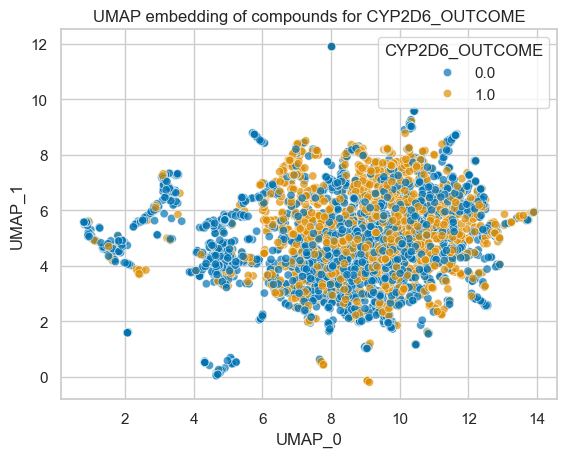

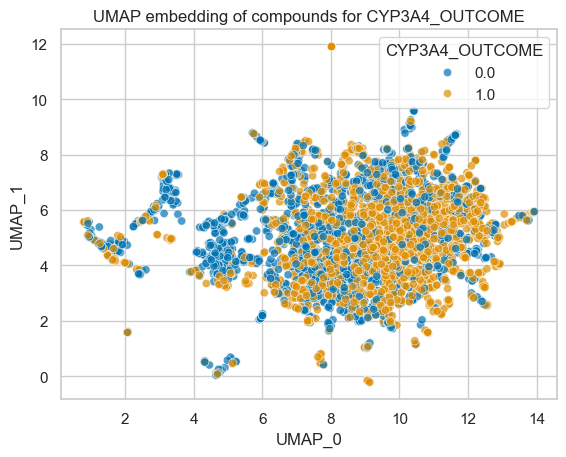

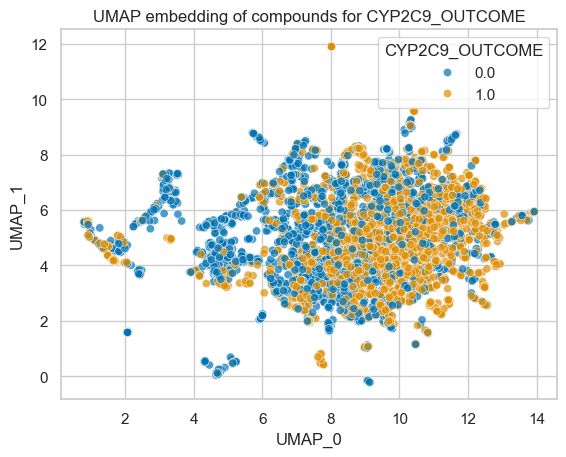

In [30]:
fig = utils.visualize_chemspace(data_look, split_names=['CYP2D6_OUTCOME', 'CYP3A4_OUTCOME', 'CYP2C9_OUTCOME'])

The active molecules for `CYP2D6`, `CYP3A4`, `CYP2C9` are widely spread in UMAP space (with parameters chosen to try to balance local and global structure). 

### Re-run curation, removing molecules as needed

The above analysis shows the CYP boiactivity can be influenced by stereochemistry information of the molecules. 
We can mask out the molecules with incomplete sterechemistry annotions. 
As usual, the duplicated molecules with conflicting bioactivities should also be removed.

In [31]:
data.reset_index(drop=True, inplace=True)
data

,PUBCHEM_SID,PUBCHEM_CID,SMILES,CYP2D6_OUTCOME,CYP2D6_SCORE,CYP3A4_OUTCOME,CYP3A4_SCORE,CYP2C9_OUTCOME,CYP2C9_SCORE
0,104223880,197033,CC1=CC2=C(C=C1)N(C3=C2CN(CC3)C)CCC4=CN=C(C=C4)C,1.0,43.0,1.0,43.0,1.0,41.0
1,11111456,5281670,C1=CC(=C(C=C1O)O)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O,0.0,0.0,0.0,0.0,NaN,NaN
2,11113977,6604832,C[C@H]1[C@@H](C(=O)N[C@H](C(=O)N2CCC[C@@H]2C(=...,0.0,0.0,NaN,NaN,NaN,NaN
3,124879150,5280443,C1=CC(=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O,1.0,41.0,1.0,84.0,1.0,41.0
4,124879975,836,C1=CC(=C(C=C1CC(C(=O)O)N)O)O,0.0,0.0,1.0,63.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5194,440681524,16741245,C[C@@](C(=O)NC1=C(C=C(C=C1)S(=O)(=O)C2=CC=C(C=...,NaN,NaN,NaN,NaN,1.0,44.0
5195,440681568,155801548,CC1=C(C(N=C(N1)NC2=NC3=CC=CC=C3O2)C4=CC=CC=C4C...,NaN,NaN,NaN,NaN,1.0,42.0
5196,440681601,9820008,COC1=CC=CC(=C1)C2=CC(=C(C=C2)NC(=O)C3=C(CCC3)C...,NaN,NaN,NaN,NaN,1.0,40.0
5197,440681615,409823,COC1=CC=C(C=C1)C2=NC3=CC=CC=C3C(=C2)C(C4CCCCN4)O,NaN,NaN,NaN,NaN,1.0,42.0


In [32]:
### Re-run the curation steps, this time removing molecules with undefined stereoisomers and removing duplicates
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    data_types = ["binary", "continuous"] *3,
    mol_col=mol_col,
    keep_all_rows=False,
)

data_curated = curator_with_stereo()

2024-04-09 11:33:34.569 | INFO     | polaris.curation._data_curator:check_outliers:176 - Outlier detection is omit for categorical data CYP2D6_OUTCOME.
2024-04-09 11:33:34.573 | INFO     | polaris.curation._data_curator:check_outliers:176 - Outlier detection is omit for categorical data CYP3A4_OUTCOME.
2024-04-09 11:33:34.575 | INFO     | polaris.curation._data_curator:check_outliers:176 - Outlier detection is omit for categorical data CYP2C9_OUTCOME.


In [33]:
data_curated

,PUBCHEM_SID,PUBCHEM_CID,SMILES,CYP2D6_OUTCOME,CYP2D6_SCORE,CYP3A4_OUTCOME,CYP3A4_SCORE,CYP2C9_OUTCOME,CYP2C9_SCORE,ORIGINAL_CYP2D6_OUTCOME,...,OUTLIER_CYP2C9_SCORE,CYP2D6_OUTCOME_stereo_cliff,CYP2D6_SCORE_zscore,CYP2D6_SCORE_stereo_cliff,CYP3A4_OUTCOME_stereo_cliff,CYP3A4_SCORE_zscore,CYP3A4_SCORE_stereo_cliff,CYP2C9_OUTCOME_stereo_cliff,CYP2C9_SCORE_zscore,CYP2C9_SCORE_stereo_cliff
0,170465735,2482,CCCCOC(=O)C1=CC=C(C=C1)N,NaN,NaN,1.0,43.0,NaN,NaN,NaN,...,None,NaN,NaN,NaN,NaN,inf,NaN,NaN,NaN,NaN
1,363678414,2799722,C1CCNC(=O)C(C1)NC(=O)C2=CC=CC=C2NC(=O)C3=CC4=C...,0.0,0.0,1.0,42.0,1.0,90.0,0.0,...,False,NaN,NaN,NaN,NaN,inf,NaN,NaN,inf,NaN
2,363677238,25102847,COC1=CC2=C(C=CN=C2C=C1OC)OC3=CC=C(C=C3)NC(=O)C...,0.0,0.0,0.0,0.0,1.0,84.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN
3,170465881,71773,CCOCC(COC1=CC=C(C=C1)NC(=O)CC[S+](C)C)O.CC1=CC...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,170466895,46861540,CN1CCC(CC1)NC2=NC=C3C(=N2)C(=NC=N3)NC4=CC(=C(C...,1.0,41.0,0.0,0.0,0.0,0.0,1.0,...,False,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,363677955,216456,C1=CC=NC(=C1)C(=O)C2=C3N=CC=C(N3N=C2)C4=CC=NC=C4,1.0,41.0,1.0,41.0,1.0,42.0,1.0,...,False,NaN,inf,NaN,NaN,inf,NaN,NaN,inf,NaN
5029,225144240,5310993,CC1=CN=C(C=[N+]1[O-])C(=O)O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5030,144206397,60196322,CCC(=O)N(C1CCN(CC1)C(C)CC2=CC=CS2)C3=CC=CC=C3.Cl,1.0,92.0,0.0,0.0,0.0,0.0,1.0,...,False,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5031,170464730,23894,CC(O)(P(=O)(O)[O-])P(=O)(O)[O-].[Na+].[Na+],0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preparing dataset annotations for upload

In [34]:
aids = ['AID_1645840', 'AID_1645841', 'AID_1645842']

names = ['CYP2D6', 'CYP3A4', 'CYP2C9']

data_cols = ['CYP2D6_OUTCOME', 'CYP2D6_SCORE', 'CYP3A4_OUTCOME', 'CYP3A4_SCORE', 'CYP2C9_OUTCOME', 'CYP2C9_SCORE']

In [35]:
sources

['https://pubchem.ncbi.nlm.nih.gov/bioassay/1645840',
 'https://pubchem.ncbi.nlm.nih.gov/bioassay/1645841',
 'https://pubchem.ncbi.nlm.nih.gov/bioassay/1645842']

In [37]:
# Dataset[0] aka 'CYP2D6'

# Additional meta-data on the column level
# The annotations here are the same for all three datasets
annotations = {
    "smiles": ColumnAnnotation(description="Molecule SMILES string", modality="molecule"),

    'CYP2D6_OUTCOME': ColumnAnnotation(description="Binarized label based on the phenotype observed, active antagonism (class = 1) if CYP2D6_SCORE between 40-100, Inactive (class = 0) if 0.",
                                user_attributes={"ref_col": 'CYP2D6_SCORE'}),
    'CYP2D6_SCORE': ColumnAnnotation(description="Average activity score of 5 replicates for CYP2D6"),
    
    'CYP3A4_OUTCOME': ColumnAnnotation(description="Binarized label based on the phenotype observed, active antagonism (class = 1) if CYP3A4_SCORE between 40-100, Inactive (class = 0) if 0.",
                                user_attributes={"ref_col": 'CYP3A4_SCORE'}),
    'CYP3A4_SCORE': ColumnAnnotation(description="Average activity score of 5 replicates for CYP2D6"),
    
    'CYP2C9_OUTCOME': ColumnAnnotation(description="Binarized label based on the phenotype observed, active antagonism (class = 1) if CYP2C9_SCORE between 40-100, Inactive (class = 0) if 0.",
                                user_attributes={"ref_col": 'CYP2D6_SCORE'}),
    'CYP2C9_SCORE': ColumnAnnotation(description="Average activity score of 5 replicates for CYP2C9"),
}



dataset = Dataset(
    # The table is the core data-structure required to construct a dataset
    table=data_curated,
    # Additional meta-data on the dataset level.
    name=f"ADME_NCATS_CYP",
    description=f"ADME Cytochrome P450 {', '.join(names)} antagonist experiment data released by the National Center for Advancing Translational Sciences",
    source="https://opendata.ncats.nih.gov/adme/data",
    annotations=annotations,
    tags=["ADME"],
    owner=HubOwner(user_id="Polaris", slug="polaris"),
    license=License(id="CC-BY-4.0"),
    user_attributes={"year": "2021"},
)

# Make a temporary directory to save the dataset
temp_dir = tempfile.TemporaryDirectory().name

save_dir = dm.fs.join(temp_dir, "dataset")

path = dataset.to_json(save_dir)

# Look at the save destination
fs = dm.fs.get_mapper(save_dir).fs
fs.ls(save_dir)

# data_curated.to_parquet(f'./data/{aids[i]}_curated.parquet') # Save just in case. Requires a data folder.

# NOTE: Commented out to not flood the DB
# with PolarisHubClient() as client:
#     client.upload_dataset(dataset=dataset)

['/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/tmp6k9pcvh7/dataset/table.parquet',
 '/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/tmp6k9pcvh7/dataset/dataset.json']

In [38]:
# Load dataset through json file given
# dataset = load_dataset(path)

In [39]:


# NOTE: Commented out to not flood the DB
# with PolarisHubClient() as client:
#     client.upload_dataset(dataset=dataset)